## 1.2 Label propagation: segmentation using just position information

In [2]:
# Import Libraries
import os
from pathlib import Path
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [3]:
# Get the current working directory
cwd = os.getcwd()
print(cwd)

d:\VS_Projects\MIRA_MISA_LABS\MISA_LAB3


### Read new test images to perform the segmentation

In [5]:
# Read patients in the test-set
test_set_path = 'data/testing-set'
aux_patients_list = os.listdir(test_set_path + '/testing-images')
list_patient = []
for str1 in aux_patients_list:
    list_patient.append(str1.replace(".nii.gz", ""))

## Preprocessing -- Skull removal step
def skull_removal(img, mask):
    brain_mask = mask>=1
    skull_strip = img*(brain_mask)
    return skull_strip

# Save array as a new nifti image
def save_as_nifti(array, filename, reference_image):
    """Save array as nifti image

    Args:
        array (array): array to be saved
        filename (str): path to save
        reference_image (str): path of reference image
    """
    reference_image = sitk.ReadImage(reference_image)
    image = sitk.GetImageFromArray(array)
    image.SetOrigin(reference_image.GetOrigin())
    image.SetSpacing(reference_image.GetSpacing())
    image.SetDirection(reference_image.GetDirection())
    sitk.WriteImage(image, filename)

def image_registration(fixed_path, moving_path):
    """Give two images and the registration of both, and its transformation map will be given

    Args:
        fixed_path (str): fixed (template) image
        moving_path (str): moving image (image that will be transformed)

    Returns:
        sitk image, transformix map: transformed image and the transformation map
    """

    fixedImage = sitk.ReadImage(fixed_path)
    movingImage = sitk.ReadImage(moving_path)

    #Start registration settings
    elastixImageFilter = sitk.ElastixImageFilter() #Image filter object
    #Defining settings
    elastixImageFilter.SetFixedImage(fixedImage)
    elastixImageFilter.SetMovingImage(movingImage)

    #Run registration
    elastixImageFilter.Execute()

    #Get result image
    resultImage = elastixImageFilter.GetResultImage()

    #Transformation map
    transformParameterMap = elastixImageFilter.GetTransformParameterMap()
    #Set resampler interpolator as NearestNeighbor
    transformParameterMap[0]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    transformParameterMap[1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]    
    transformParameterMap[2]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    return resultImage, transformParameterMap

In [26]:
# TRansform atlas images to the same space as the fixed image per each image
atlas_path_csf = str(cwd) + f'/data/our_atlas/csf_atlas.nii'
atlas_path_gm = str(cwd) + f'/data/our_atlas/gm_atlas.nii'
atlas_path_wm = str(cwd) + f'/data/our_atlas/wm_atlas.nii'

def transform_atlas(atlas_path_csf, atlas_path_gm, atlas_path_wm, transformParameterMap):

    atlas_csf = sitk.ReadImage(atlas_path_csf) #Read labels
    atlas_gm = sitk.ReadImage(atlas_path_gm) #Read labels
    atlas_wm = sitk.ReadImage(atlas_path_wm) #Read labels
    
    transformixImageFilter = sitk.TransformixImageFilter() #Create object transform matrix
    transformixImageFilter.SetTransformParameterMap(transformParameterMap) #Set with found transform map
    transformixImageFilter.SetMovingImage(atlas_csf) #set moving image
    transformixImageFilter.Execute() # Execute transform
    atlas_csf_registered = transformixImageFilter.GetResultImage() #Get result image

    transformixImageFilter.SetMovingImage(atlas_gm) #set moving image
    transformixImageFilter.Execute() # Execute transform
    atlas_gm_registered = transformixImageFilter.GetResultImage() #Get result image

    transformixImageFilter.SetMovingImage(atlas_wm) #set moving image
    transformixImageFilter.Execute() # Execute transform
    atlas_wm_registered = transformixImageFilter.GetResultImage() #Get result image

    return atlas_csf_registered, atlas_gm_registered, atlas_wm_registered   
    
# Go through all the patients in the test-set
for patient in list_patient:
    print(patient)
    # Read the images
    fixed_path = str(cwd) + f'/data/testing-set/testing-images/{patient}.nii.gz'
    labels_path = str(cwd) + f'/data/testing-set/testing-labels/{patient}_3C.nii.gz'
    moving_path = str(cwd) + f'/data/training-set/training-images/1011.nii.gz'
    # Register the images
    resultImage, transformParameterMap = image_registration(fixed_path, moving_path)
    # Transform the atlas images
    atlas_csf_registered, atlas_gm_registered, atlas_wm_registered = transform_atlas(atlas_path_csf, atlas_path_gm, atlas_path_wm, transformParameterMap)
    # Save the transformed atlas images
    save_as_nifti(sitk.GetArrayFromImage(atlas_csf_registered), f'data/transformed_atlas/csf_atlas_{patient}.nii.gz', fixed_path)
    save_as_nifti(sitk.GetArrayFromImage(atlas_gm_registered), f'data/transformed_atlas/gm_atlas_{patient}.nii.gz', fixed_path)
    save_as_nifti(sitk.GetArrayFromImage(atlas_wm_registered), f'data/transformed_atlas/wm_atlas_{patient}.nii.gz', fixed_path)

1003
1004
1005
1018
1019
1023
1024
1025
1038
1039
1101
1104
1107
1110
1113
1116
1119
1122
1125
1128


### Apply Segmentation using transformed atlasses

In [18]:
def dice_score(image1, image2):
    image1 = sitk.GetArrayFromImage(image1)
    image2 = sitk.GetArrayFromImage(image2)
    image1[image1 > 0] = 1
    image2[image2 > 0] = 1
    intersection = np.sum(np.multiply(image1, image2))
    dice = 2 * intersection / (np.sum(image1) + np.sum(image2))
    return dice

def get_dice_score(list_patient):
    ds_csf = []
    ds_gm = []
    ds_wm = []

    for i in range(len(list_patient)):
        seg_path = str(cwd) + f'/data/LP_segmentation/atlas_labels_{list_patient[i]}.nii.gz'
        label_path = str(cwd) + f'/data/testing-set/testing-labels/{list_patient[i]}_3C.nii.gz'
        seg_image = sitk.ReadImage(seg_path)
        label_image = sitk.ReadImage(label_path)
        for i in range(1, 4):
            d = dice_score(seg_image == i, label_image == i)
            if i == 1:
                ds_csf.append(d)
            elif i == 2:
                ds_gm.append(d)
            else:
                ds_wm.append(d)

    # save the dice scores as a csv file
    df = pd.DataFrame({'CSF': ds_csf, 'GM': ds_gm, 'WM': ds_wm})
    df.to_csv(str(cwd) + f'/data/LP_segmentation/dice_scores.csv', index=False)

    return df

In [15]:
# Apply segmentation using the transformed atlas images
def segmentation(list_patient):
    for p in list_patient:
        # Read transformed atlas images
        # Atlasses registered to the template space (1011.nii.gz)
        atlas_csf = sitk.ReadImage(str(cwd) + f'/data/transformed_atlas/csf_atlas_{p}.nii.gz')
        atlas_gm = sitk.ReadImage(str(cwd) + f'/data/transformed_atlas/gm_atlas_{p}.nii.gz')
        atlas_wm = sitk.ReadImage(str(cwd) + f'/data/transformed_atlas/wm_atlas_{p}.nii.gz')

        # Read the image to be segmented
        fixed_path = str(cwd) + f'/data/testing-set/testing-images/{p}.nii.gz'

        # select the maximum value of the atlas images to perform segmentation
        atlas_csf1 = sitk.GetArrayFromImage(atlas_csf)
        atlas_gm1 = sitk.GetArrayFromImage(atlas_gm)
        atlas_wm1 = sitk.GetArrayFromImage(atlas_wm)

        # get the tissue with the highest value
        array = [atlas_csf1, atlas_wm1, atlas_gm1]

        # get sum of the atlasses to make a mask
        # in this way, we can make sure that the segmentation is only performed in the brain
        sum_atlas = atlas_csf1 + atlas_gm1 + atlas_wm1
        sum_atlas[sum_atlas > 0] = 1
        plt.imshow(sum_atlas[100, :, :])

        # get the tissue with the highest value (GET ATLAS LABELS)   
        atlas_labels = np.argmax(array, axis=0)+1 # add 1 to get the labels 1, 2, 3 not 0, 1, 2

        # mask the atlas
        atlas_labels = atlas_labels * sum_atlas

        # save the atlas labels as a nifti file
        save_as_nifti(atlas_labels, f'data/LP_segmentation/atlas_labels_{p}.nii.gz', fixed_path)


[1 2 3]


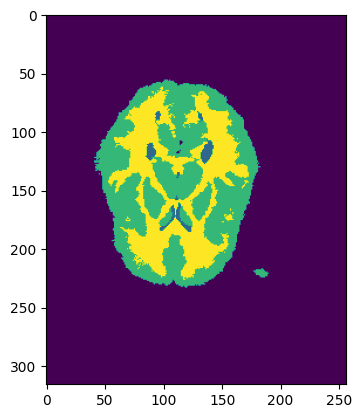

In [13]:
# Test
# p =1003
# atlas_csf_registered = sitk.ReadImage(str(cwd) + f'/data/transformed_atlas/csf_atlas_{p}.nii.gz')
# atlas_gm_registered = sitk.ReadImage(str(cwd) + f'/data/transformed_atlas/gm_atlas_{p}.nii.gz')
# atlas_wm_registered = sitk.ReadImage(str(cwd) + f'/data/transformed_atlas/wm_atlas_{p}.nii.gz')

# # Read the image to be segmented
# fixed_path = str(cwd) + f'/data/testing-set/testing-images/{p}.nii.gz'

# # select the maximum value of the atlas images to perform segmentation
# atlas_csf_registered1 = sitk.GetArrayFromImage(atlas_csf_registered)
# atlas_gm_registered1 = sitk.GetArrayFromImage(atlas_gm_registered)
# atlas_wm_registered1 = sitk.GetArrayFromImage(atlas_wm_registered)

# # get the tissue with the highest value
# array = [atlas_csf_registered1, atlas_gm_registered1, atlas_wm_registered1]

# # get sum of the atlasses to make a mask
# sum_atlas = atlas_csf_registered1 + atlas_gm_registered1 + atlas_wm_registered1
# sum_atlas[sum_atlas > 0] = 1
# plt.imshow(sum_atlas[150, :, :])
# atlas_labels = np.argmax(array, axis=0)+1
# plt.imshow(atlas_labels[150, :, :])
# print(np.unique(atlas_labels))
# atlas_labels = atlas_labels * sum_atlas
# plt.imshow(atlas_labels[150, :, :])

# save_as_nifti(atlas_labels, f'data/LP_segmentation/atlas_labels_{p}.nii.gz', fixed_path)

# ds_csf = []
# ds_gm = []
# ds_wm = []
# label_path = str(cwd) + f'/data/testing-set/testing-labels/{p}_3C.nii.gz'
# seg_path = str(cwd) + f'/data/LP_segmentation/atlas_labels_{p}.nii.gz'
# label_image = sitk.ReadImage(label_path)
# seg_image = sitk.ReadImage(seg_path)
# for i in range(1, 4):
#     d = dice_score(seg_image == i, label_image == i)
#     if i == 1:
#         ds_csf.append(d)
#     elif i == 2:
#         ds_gm.append(d)
#     else:
#         ds_wm.append(d)
# df = pd.DataFrame({'CSF': ds_csf, 'GM': ds_gm, 'WM': ds_wm})

In [19]:
# Get dice score from the label propagation segmentation results
get_dice_score(list_patient)

,CSF,GM,WM
0,0.570480,0.769989,0.702738
1,0.767377,0.766149,0.707968
2,0.784157,0.726679,0.660353
3,0.778751,0.769281,0.715360
4,0.611740,0.744203,0.675515
5,0.593975,0.765710,0.709617
6,0.761205,0.760409,0.729221
7,0.754742,0.722471,0.679995
8,0.775377,0.771818,0.709064
9,0.611969,0.745815,0.659522


## 1.3 Bayesian Approach: Combine tissue models and label propagation segmentations (segmentation using intensity + position information)

In [ ]:
# Load TM segmentations and LP segmentations
TM_seg = []
LP_seg = []
for p in list_patient:
    TM_seg_path = str(cwd) + f'/data/TM_segmentation/tm_seg_{p}_3C.nii'
    TM_seg.append(sitk.GetArrayFromImage(sitk.ReadImage(TM_seg_path)))
    LP_seg_path = str(cwd) + f'/data/LP_segmentation/segmented_{p}.nii.gz'
    LP_seg.append(sitk.GetArrayFromImage(sitk.ReadImage(LP_seg_path)))
